In [23]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import os
from datetime import datetime
from collections import defaultdict
import bisect
from math import sqrt

In [2]:
path = 'Corr_data/'
os.listdir(path)

['inp_z_filter.csv',
 'imp.csv',
 'out_gk_filter.csv',
 'out_gk_filter_test.csv',
 'inp_z_filter_test.csv']

In [3]:
X0 = pd.read_csv('Corr_data/inp_z_filter.csv', names = ['{}'.format(i) for i in range(5)])
X0_test = pd.read_csv('Corr_data/inp_z_filter_test.csv', names = ['{}'.format(i) for i in range(5)])
Y0 = pd.read_csv('Corr_data/out_gk_filter.csv', names = ['{}'.format(i) for i in range(2)])
Y0_test = pd.read_csv('Corr_data/out_gk_filter_test.csv', names = ['{}'.format(i) for i in range(2)])
X0.head()

,0,1,2,3,4
0,1,0.000000,0.000000,0.000000,0.000000
1,1,0.000000,0.000000,0.000000,0.000000
2,1,-0.001160,0.000000,-0.001160,0.000000
3,1,-0.003311,0.001248,-0.002151,0.001248
4,1,-0.005148,0.003561,-0.001837,0.002313


In [4]:
Y0.head()

,0,1
0,1,-0.003641
1,1,-0.010413
2,1,-0.014985
3,1,-0.016695
4,1,-0.017878


In [5]:
print(len(Y0),len(Y0_test))

116448 58224


In [6]:
from scipy import *
from scipy.linalg import norm, pinv
import math
from sklearn.linear_model import LinearRegression

from matplotlib import pyplot as plt

# y = Wx + P
class RBF:
     
    def __init__(self, indim, outdim, center_inds):
        self.indim = indim
        self.center_inds = center_inds
        self.outdim = outdim
        self.numCenters = len(self.center_inds)
        self.centers = [np.random.uniform(-1, 1, indim) for i in range(self.numCenters)]
        self.W = np.random.random((self.numCenters, self.outdim))
        self.P = LinearRegression()
        self.lr = LinearRegression()
         
    def _basisfunc(self, c, d):
        assert len(d) == self.indim
        return norm(c-d)**1.5
     
    def _calcAct(self, X):
        # calculate activations of RBFs
        G = np.zeros((X.shape[0], self.numCenters), float)
        for ci, c in enumerate(self.centers):
            for xi, x in enumerate(X):
                G[xi,ci] = self._basisfunc(c, x)
        return G
     
    def train(self, X, Y):
        """ X: matrix of dimensions n x indim 
            y: column vector of dimension n x 1 """
         
        # choose random center vectors from training set
        self.P.fit(X,Y)
        rnd_idx = self.center_inds
        self.centers = [X[i,:] for i in rnd_idx]
         
        # print("center", self.centers)
        # calculate activations of RBFs
        G = self._calcAct(X)
        # print(G) 
        # calculate output weights (pseudoinverse)
        self.W = np.dot(pinv(G), Y)
        val = np.zeros((len(X),2))
        val[:,0] = np.dot(G, self.W)
        val[:,1] = self.P.predict(X)
        # print(val.shape)
        self.lr.fit(val,Y)
        
         
    def test(self, X):
        """ X: matrix of dimensions n x indim """
         
        G = self._calcAct(X)
        Y = np.dot(G, self.W)
        Y2 = self.P.predict(X)
        val = np.zeros((len(X),2))
        val[:,0] = Y
        val[:,1] = Y2
        return self.lr.predict(val)

In [7]:
def FBL(value):
    start,end = bisect.bisect_left(Y0.iloc[:,0],value), bisect.bisect_right(Y0.iloc[:,0],value)
    x = np.array(X0.iloc[start:end,1:])
    y = np.array(Y0.iloc[start:end,1])
    
    centers_ind = [1]
    got = defaultdict(lambda : 1)
    got[1]=0
    if 1 == 1:
        rbf = RBF(4, 1,centers_ind)
        rbf.train(x, y)

        y1 = rbf.test(x)
        maxi,ind = 0,0
        for i in range(len(y)):
            if i not in centers_ind and norm(y[i]-y1[i])/(1+norm(y[i]))>maxi:
                maxi = norm(y[i]-y1[i])/(1+norm(y[i]))
                ind = i
        p = 0.7
        error = mean_squared_error(y,y1)**p
        while error<0.15 and p>0:
            p -= 0.015
            error = mean_squared_error(y,y1)**p
        while error>0.15 and len(centers_ind)<len(y)//5:
            centers_ind.append(ind)
            for j in range(ind-3,ind+3):
                got[j]=0
            rbf = RBF(4, 1, centers_ind)
            rbf.train(x,y)

            y1 = rbf.test(x)

            maxi,ind = 0,0
            for i in range(len(y)):
                if got[i] and norm(y[i]-y1[i])/(1+norm(y[i]))>maxi:
                    maxi = norm(y[i]-y1[i])/(1+norm(y[i]))
                    ind = i
            error = mean_squared_error(y,y1)**p
            #print(error,ind)
        #print(centers_ind)
        return centers_ind,start

In [8]:
t1 = datetime.now()

Final_indices = []
important_interactions = [2, 79, 91, 86, 82, 100, 11, 103, 7, 23, 26, 3, 19, 95, 117]

for i in important_interactions:
    points, val = FBL(i)
    print(len(points), end = ' ')
    for j in points:
        Final_indices.append(j+val)


23 3 2 13 40 4 2 3 28 2 2 22 22 15 2 

In [9]:
len(Final_indices)

183

In [10]:
class RBF1:
     
    def __init__(self, indim,outdim, centers_ind):
        self.indim = indim
        self.outdim = outdim
        self.numCenters = len(centers_ind)
        self.centers_ind = centers_ind
        self.centers = [np.random.uniform(-1, 1, indim) for i in range(self.numCenters)]
        self.beta = 8
        self.W = np.random.random((self.numCenters, self.outdim))
         
    def _basisfunc(self, c, d):
        assert len(d) == self.indim
        return norm(c-d)**3
     
    def _calcAct(self, X):
        # calculate activations of RBFs
        G = np.zeros((X.shape[0], self.numCenters), float)
        for ci, c in enumerate(self.centers):
            for xi, x in enumerate(X):
                G[xi,ci] = self._basisfunc(c, x)
        return G
     
    def train(self, X, Y):
        """ X: matrix of dimensions n x indim 
            y: column vector of dimension n x 1 """
         
        # choose random center vectors from training set
        rnd_idx = self.centers_ind
        self.centers = [X[i,:] for i in rnd_idx]
         
        #print("center", self.centers)
        # calculate activations of RBFs
        G = self._calcAct(X)
        #print(G)
         
        # calculate output weights (pseudoinverse)
        self.W = np.dot(pinv(G), Y)
         
    def test(self, X):
        """ X: matrix of dimensions n x indim """
         
        G = self._calcAct(X)
        Y = np.dot(G, self.W)
        return Y

In [11]:
t2 = datetime.now()
x = np.array(X0.iloc[:,1:])
y = np.array(Y0.iloc[:,1])

rbf = RBF1(4, 1,Final_indices)
rbf.train(x, y)
t3 = datetime.now()

In [12]:
print('time taken by entire FBL:', t3-t1)
print('Important point calculation time:', t2-t1)

time taken by entire FBL: 0:03:21.191213
Important point calculation time: 0:00:27.936723


In [13]:
x_test = np.array(X0_test.iloc[:,1:])
y_test = np.array(Y0_test.iloc[:,1])
y1 = rbf.test(x_test)
print('Root Mean Squared error: ', mean_squared_error(y_test,y1)**0.5)

Root Mean Squared error:  0.06806366407963775


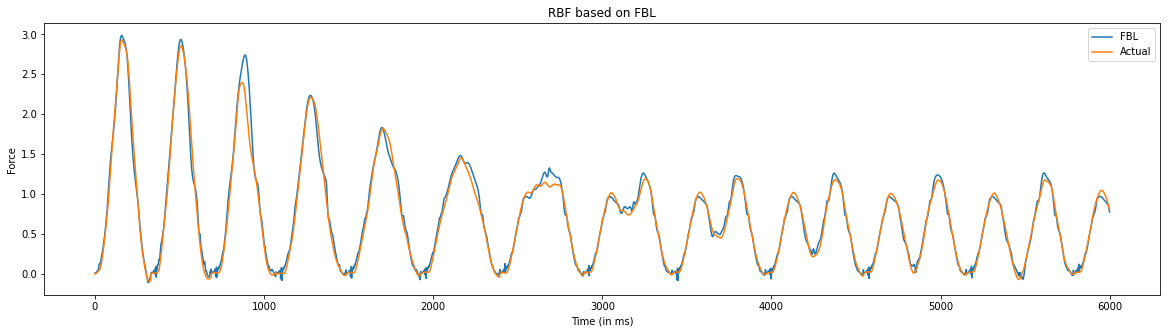

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
plt.plot(list(range(6000)),y1[:6000], label = 'FBL')
plt.plot(list(range(6000)),y_test[:6000], label = 'Actual')
plt.legend()
plt.xlabel('Time (in ms)')
plt.ylabel('Force')
plt.title('RBF based on FBL')
plt.show()

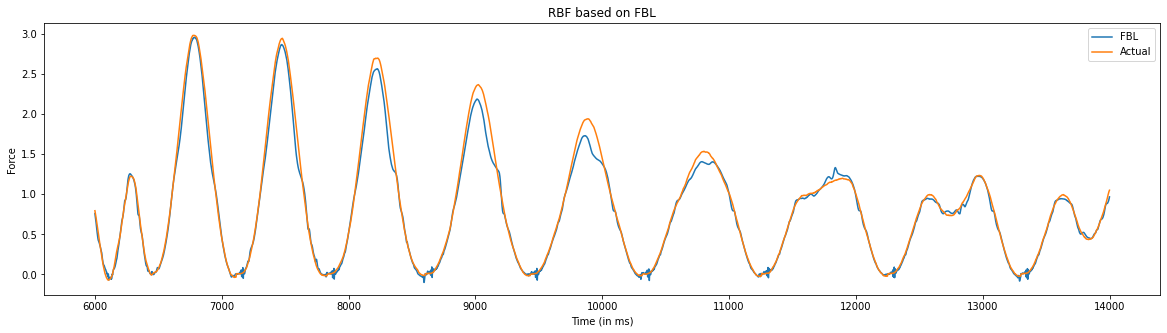

In [15]:
plt.figure(figsize=(20,5))
plt.plot(list(range(6000,14000)),y1[6000:14000], label = 'FBL')
plt.plot(list(range(6000,14000)),y_test[6000:14000], label = 'Actual')
plt.legend()
plt.xlabel('Time (in ms)')
plt.ylabel('Force')
plt.title('RBF based on FBL')
plt.show()

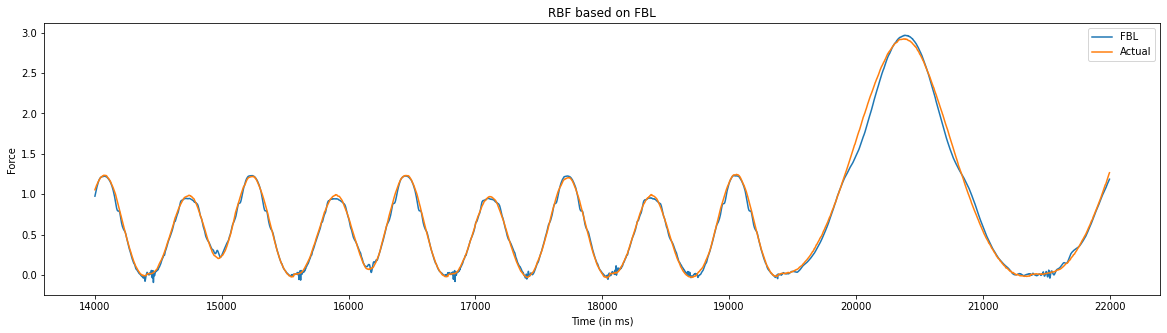

In [16]:
plt.figure(figsize=(20,5))
plt.plot(list(range(14000,22000)),y1[14000:22000], label = 'FBL')
plt.plot(list(range(14000,22000)),y_test[14000:22000], label = 'Actual')
plt.legend()
plt.xlabel('Time (in ms)')
plt.ylabel('Force')
plt.title('RBF based on FBL')
plt.show()

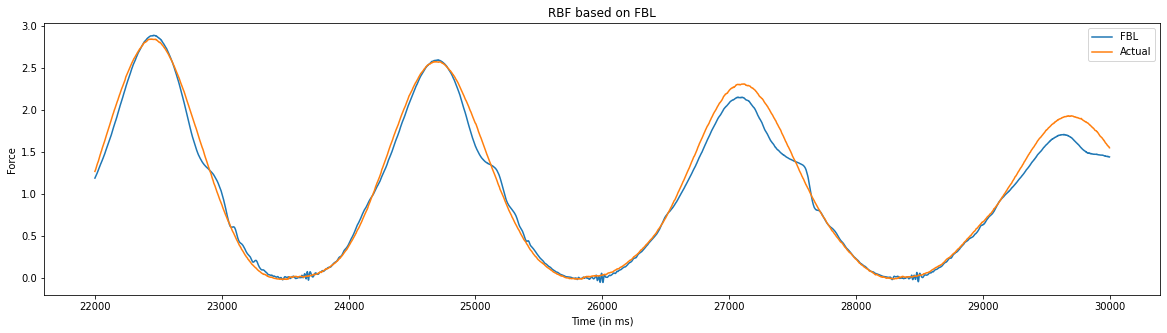

In [17]:
plt.figure(figsize=(20,5))
plt.plot(list(range(22000,30000)),y1[22000:30000], label = 'FBL')
plt.plot(list(range(22000,30000)),y_test[22000:30000], label = 'Actual')
plt.legend()
plt.xlabel('Time (in ms)')
plt.ylabel('Force')
plt.title('RBF based on FBL')
plt.show()

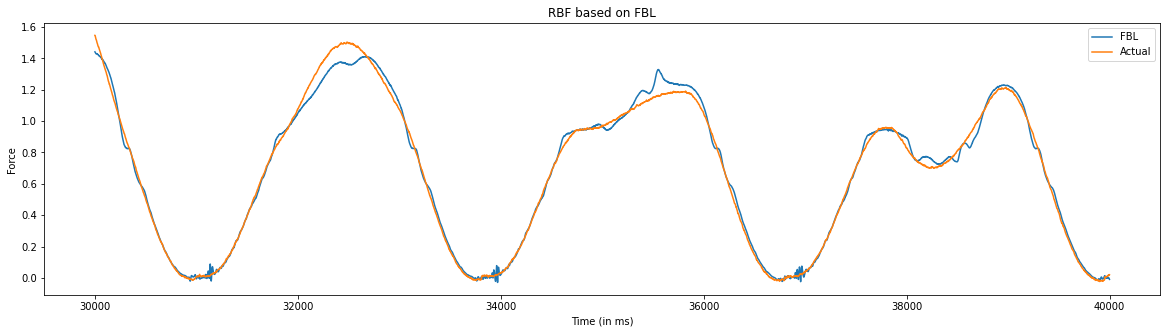

In [18]:
plt.figure(figsize=(20,5))
plt.plot(list(range(30000,40000)),y1[30000:40000], label = 'FBL')
plt.plot(list(range(30000,40000)),y_test[30000:40000], label = 'Actual')
plt.legend()
plt.xlabel('Time (in ms)')
plt.ylabel('Force')
plt.title('RBF based on FBL')
plt.show()

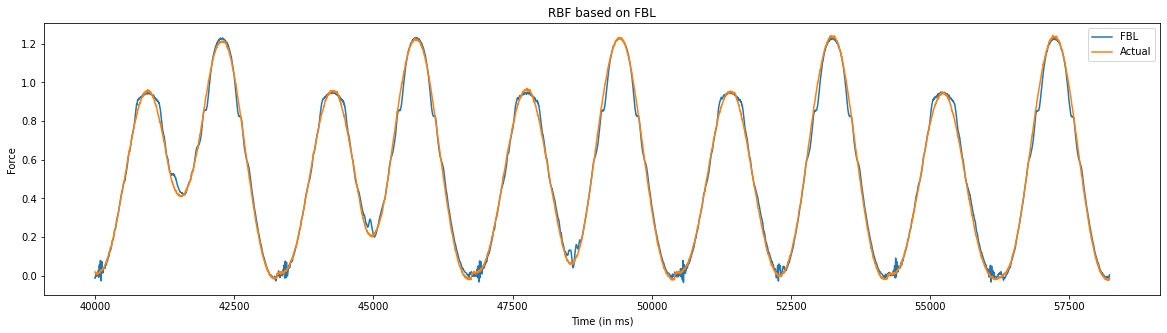

In [19]:
plt.figure(figsize=(20,5))
plt.plot(list(range(40000,58223)),y1[40000:58223], label = 'FBL')
plt.plot(list(range(40000,58223)),y_test[40000:58223], label = 'Actual')
plt.legend()
plt.xlabel('Time (in ms)')
plt.ylabel('Force')
plt.title('RBF based on FBL')
plt.show()

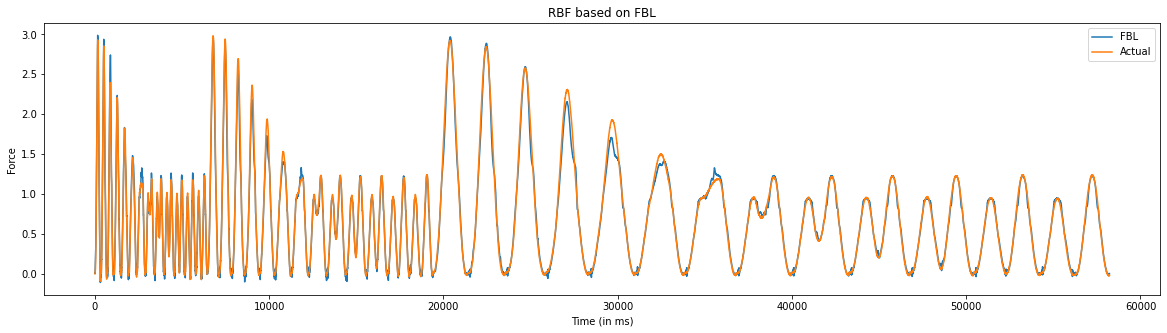

In [20]:
plt.figure(figsize=(20,5))
plt.plot(list(range(58223)),y1[:58223], label = 'FBL')
plt.plot(list(range(58223)),y_test[:58223], label = 'Actual')
plt.legend()
plt.xlabel('Time (in ms)')
plt.ylabel('Force')
plt.title('RBF based on FBL')
plt.savefig('FBL_filtered.jpg')
plt.show()

In [21]:
error5 = []
for i in range(len(y_test)):
    error5.append(abs(y1[i]-y_test[i]))
print('Minimum Error =',min(error5))
print('Maximum Error =',max(error5))
error6 = sorted(error5)
print('Median Value of Error =',error6[len(error5)//2])

Minimum Error = 1.4648540101400154e-08
Maximum Error = 0.6767472630124538
Median Value of Error = 0.021319995956519844


# Catboost on present data

In [22]:
from catboost import CatBoostRegressor
cat = CatBoostRegressor()
t1 = datetime.now()
cat.fit(x,y)
t2 = datetime.now()

Learning rate set to 0.086822
0:	learn: 0.9224195	total: 69ms	remaining: 1m 8s
1:	learn: 0.8460820	total: 77.5ms	remaining: 38.7s
2:	learn: 0.7767842	total: 83ms	remaining: 27.6s
3:	learn: 0.7138652	total: 88.8ms	remaining: 22.1s
4:	learn: 0.6560713	total: 93.7ms	remaining: 18.6s
5:	learn: 0.6030103	total: 98.7ms	remaining: 16.3s
6:	learn: 0.5544957	total: 104ms	remaining: 14.7s
7:	learn: 0.5110606	total: 109ms	remaining: 13.5s
8:	learn: 0.4709531	total: 113ms	remaining: 12.4s
9:	learn: 0.4337034	total: 117ms	remaining: 11.6s
10:	learn: 0.3998766	total: 121ms	remaining: 10.9s
11:	learn: 0.3688631	total: 126ms	remaining: 10.4s
12:	learn: 0.3404614	total: 130ms	remaining: 9.87s
13:	learn: 0.3143670	total: 135ms	remaining: 9.47s
14:	learn: 0.2903333	total: 139ms	remaining: 9.1s
15:	learn: 0.2684238	total: 143ms	remaining: 8.79s
16:	learn: 0.2487280	total: 148ms	remaining: 8.55s
17:	learn: 0.2305573	total: 153ms	remaining: 8.34s
18:	learn: 0.2139614	total: 157ms	remaining: 8.13s
19:	learn:

In [24]:
print('Time taken by Cat Boosting:',t2-t1)

y_pred = cat.predict(x_test)
print('Root mean square error of Cat Boost Model: ',sqrt(mean_squared_error(y_test,y_pred)))

Time taken by Cat Boosting: 0:00:05.019720
Root mean square error of Cat Boost Model:  0.0407483188423152


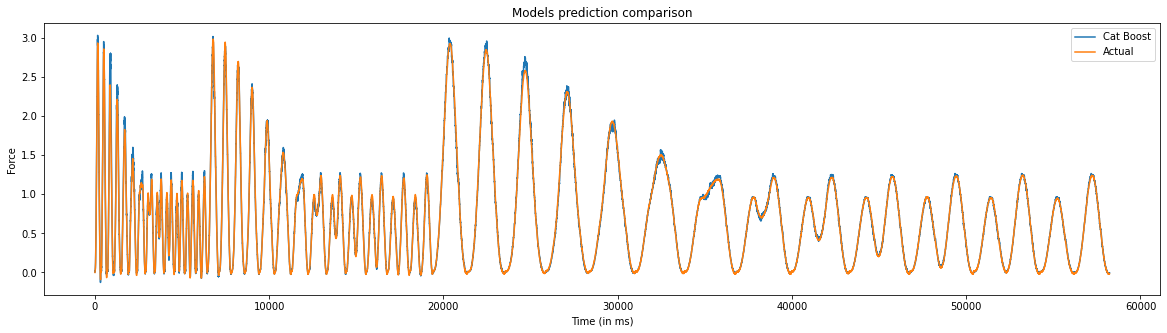

In [25]:
plt.figure(figsize=(20,5))
plt.plot(list(range(58223)),y_pred[:58223], label = 'Cat Boost')
plt.plot(list(range(58223)),y_test[:58223], label = 'Actual')
plt.legend()
plt.xlabel('Time (in ms)')
plt.ylabel('Force')
plt.title('Models prediction comparison')
plt.savefig('catboost_present_filtered.jpg')
plt.show()